In [1]:
import numpy as np
import pandas as pd
import math
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

### Load Data

In [2]:
df_sentiment = pd.read_csv('sentiment_model_result.csv') #sentiment using probability
df_sentiment_comm = pd.read_csv('sentiment_committee_model_result.csv') #sentiment using committee

In [3]:
df_sentiment.head(2)

,Unnamed: 0,model_name,training_method,balance,sampling_size,sort_by_time,partition_ratio,seed_size,unlabeled_size,test_size,...,accuracy,f1_micro,f1_macro,f1_weighted,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted
0,1,Multinomial Naive Bayes,random_sampling,True,0,True,"[0.1, 0.45, 0.45]",39,186,192,...,0.354,0.354,0.351,0.351,0.354,0.373,0.373,0.354,0.354,0.354
1,2,Multinomial Naive Bayes,random_sampling,True,0,True,"[0.5, 0.25, 0.25]",207,102,108,...,0.583,0.583,0.579,0.579,0.583,0.612,0.612,0.583,0.583,0.583


In [4]:
df_sentiment_comm.head(2)

,Unnamed: 0,model_names,training_method,balance,sampling_size,sort_by_time,partition_ratio,seed_size,unlabeled_size,test_size,accuracy,f1_micro,f1_macro,f1_weighted,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted
0,1,"SVC, KNN, Decision Tree, Random Forest, AdaBoost",random_sampling,True,0,True,"[0.1, 0.45, 0.45]",39,186,192,0.2822,0.2822,0.2382,0.2382,0.2822,0.2944,0.2944,0.2822,0.2822,0.2822
1,2,"SVC, KNN, Decision Tree, Random Forest, AdaBoost",random_sampling,True,0,True,"[0.5, 0.25, 0.25]",207,102,108,0.5206,0.5206,0.4974,0.4974,0.5206,0.5202,0.5202,0.5206,0.5206,0.5206


### Data Preprocessing

In [5]:
feat_lst = ['model_name', 'balance', 'sort_by_time', 'learning_strategy', 'partition_ratio', 'sampling_size']
metric_lst_c = ['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted', 'precision_micro', 'precision_macro', 'precision_weighted', 
                 'recall_micro', 'recall_macro', 'recall_weighted'] #(model_stats_sentiment)
sent_col = feat_lst + metric_lst_c
strategies = ['probability', 'committee']
sentiment_diff_col = ['accuracy_diff_probability', 'f1_micro_diff_probability', 'f1_macro_diff_probability', 'f1_weighted_diff_probability', 'precision_micro_diff_probability', 'precision_macro_diff_probability', 'precision_weighted_diff_probability', 
                                   'recall_micro_diff_probability', 'recall_macro_diff_probability', 'recall_weighted_diff_probability',
                                   'accuracy_diff_committee', 'f1_micro_diff_committee', 'f1_macro_diff_committee', 'f1_weighted_diff_committee', 'precision_micro_diff_committee', 'precision_macro_diff_committee', 'precision_weighted_diff_committee', 
                                   'recall_micro_diff_committee', 'recall_macro_diff_committee', 'recall_weighted_diff_committee']

In [6]:
def assign_learning_strategy_prob(x):
    if x == 'random_sampling':
        return 'random_sampling_probability'
    else:
        return 'active_learning_probability'
    
def assign_learning_strategy_comm(x):
    if x == 'random_sampling':
        return 'random_sampling_committee'
    else:
        return 'active_learning_committee'

In [7]:
df_sentiment['learning_strategy'] = df_sentiment['training_method'].apply(assign_learning_strategy_prob)
df_sentiment_comm['learning_strategy'] = df_sentiment_comm['training_method'].apply(assign_learning_strategy_comm)
df_sentiment = df_sentiment[sent_col]
df_sentiment_comm=df_sentiment_comm.rename(columns={"model_names": "model_name"})[sent_col]
sentiment = pd.concat([df_sentiment, df_sentiment_comm])

#### Create pivot table

In [8]:
sentiment_pivot = sentiment.pivot_table(metric_lst_c, ['model_name', 'balance', 'sort_by_time', 'partition_ratio', 'sampling_size'], 'learning_strategy')
sentiment_pivot = sentiment_pivot.reset_index()
sentiment_pivot.columns = [sentiment_pivot.columns.values[i][0] if i < 5 else '_'.join(sentiment_pivot.columns.values[i]) for i in range(len(sentiment_pivot.columns.values))]

for m in metric_lst_c:
    for s in strategies:
        diff_col = m + '_diff_' + s 
        al_col, rs_col = m + '_active_learning_' + s, m + '_random_sampling_' + s
        sentiment_pivot[diff_col] = sentiment_pivot[al_col] - sentiment_pivot[rs_col]
    
sentiment_stats = sentiment_pivot[[f for f in feat_lst if f != 'learning_strategy'] + sentiment_diff_col]

<AxesSubplot:>

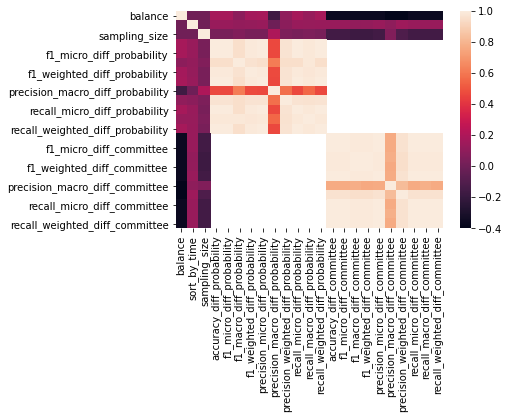

In [9]:
sentiment_corr_plot=sns.heatmap(sentiment_stats.corr())
sentiment_corr_plot

In [10]:
# sns.pairplot(bucket_stats)

### Measure the effect of Active Learning (One Tailed Paired T-test)

#### Assumptions

As a parametric procedure (a procedure which estimates unknown parameters), the paired sample t-test makes several assumptions. Although t-tests are quite robust, it is good practice to evaluate the degree of deviation from these assumptions in order to assess the quality of the results. In a paired sample t-test, the observations are defined as the differences between two sets of values, and each assumption refers to these differences, not the original data values. The paired sample t-test has four main assumptions:

- The dependent variable must be continuous (interval/ratio).
- The observations are independent of one another.
- The dependent variable should be approximately normally distributed.
- The dependent variable should not contain any outliers.

**Level of Measurement**

The paired sample t-test requires the sample data to be numeric and continuous, as it is based on the normal distribution. Continuous data can take on any value within a range (income, height, weight, etc.). The opposite of continuous data is discrete data, which can only take on a few values (Low, Medium, High, etc.). Occasionally, discrete data can be used to approximate a continuous scale, such as with Likert-type scales.

**Independence**

Independence of observations is usually not testable, but can be reasonably assumed if the data collection process was random without replacement. In our example, it is reasonable to assume that the participating employees are independent of one another.

**Normality**

To test the assumption of normality, a variety of methods are available, but the simplest is to inspect the data visually using a tool like a histogram. Real-world data are almost never perfectly normal, so this assumption can be considered reasonably met if the shape looks approximately symmetric and bell-shaped. The data in the example figure below is approximately normally distributed.

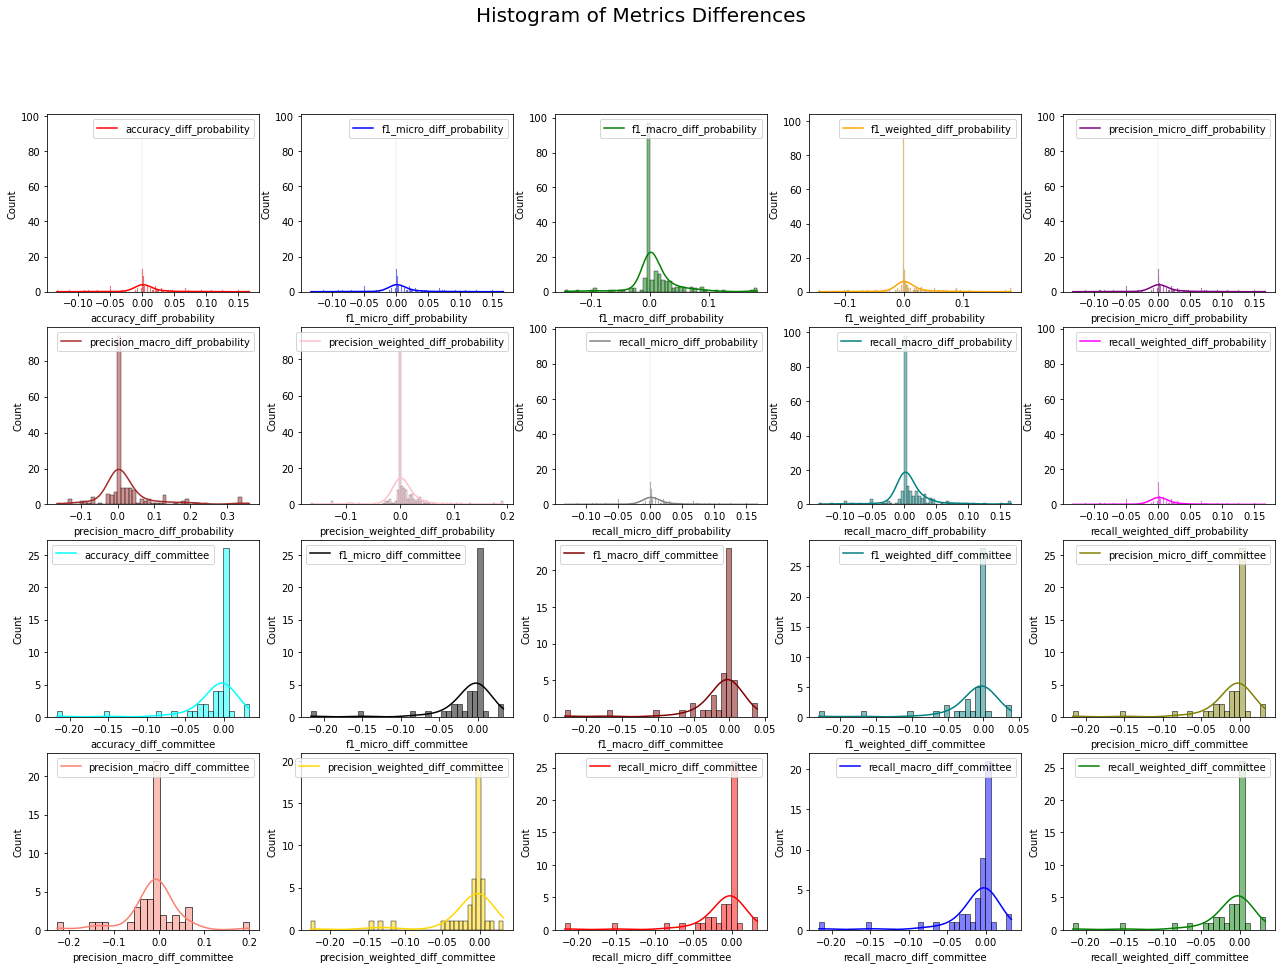

In [11]:
def plot_dist(df, df_col, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'teal', 'magenta', 'cyan', 'black', 
              'maroon', 'teal', 'olive', 'salmon', 'gold', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'teal', 'magenta', 'cyan', 'black']  
    row, col = 0, 0
    for i in range(len(df_col)):
        x = df_col[i]
        c = colors[i]
        sns.histplot(data=df, x=x, kde=True, color=c, alpha=0.5, ax=axes[row, col])
        axes[row, col].legend(labels=[x])
        if col < (ncols - 1):
            col += 1
        else:
            row += 1
            col = 0
    fig.suptitle('Histogram of Metrics Differences', fontsize=20)
    plt.show()
    
plot_dist(sentiment_stats, sentiment_diff_col, 4, 5, (22, 15))

**Outliers**

Outliers are rare values that appear far away from the majority of the data. Outliers can bias the results and potentially lead to incorrect conclusions if not handled properly. One method for dealing with outliers is to simply remove them. However, removing data points can introduce other types of bias into the results, and potentially result in losing critical information. If outliers seem to have a lot of influence on the results, a nonparametric test such as the Wilcoxon Signed Rank Test may be appropriate to use instead. Outliers can be identified visually using a boxplot.

In [12]:
# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
# sns.boxplot(data=bucket_stats, x='accuracy_diff_probability', color='red', ax=axes[0, 0])
# sns.boxplot(data=bucket_stats, x='f1_score_diff_probability', color='blue', ax=axes[0, 1])
# sns.boxplot(data=bucket_stats, x='precision_diff_probability', color='green', ax=axes[0, 2])
# sns.boxplot(data=bucket_stats, x='recall_diff_probability', color='orange', ax=axes[0, 3])
# sns.boxplot(data=bucket_stats, x='specificity_diff_probability', color='purple', ax=axes[0, 4])
# sns.boxplot(data=bucket_stats, x='accuracy_diff_committee', color='brown', ax=axes[1, 0])
# sns.boxplot(data=bucket_stats, x='f1_score_diff_committee', color='pink', ax=axes[1, 1])
# sns.boxplot(data=bucket_stats, x='precision_diff_committee', color='gray', ax=axes[1, 2])
# sns.boxplot(data=bucket_stats, x='recall_diff_committee', color='teal', ax=axes[1, 3])
# sns.boxplot(data=bucket_stats, x='specificity_diff_committee', color='magenta', ax=axes[1, 4])
# axes[0, 0].legend(labels=['accuracy_diff_probability'])
# axes[0, 1].legend(labels=['f1_score_diff_probability'])
# axes[0, 2].legend(labels=['precision_diff_probability'])
# axes[0, 3].legend(labels=['recall_diff_probability'])
# axes[0, 4].legend(labels=['specificity_diff_probability'])
# axes[1, 0].legend(labels=['accuracy_diff_committee'])
# axes[1, 1].legend(labels=['f1_score_diff_committee'])
# axes[1, 2].legend(labels=['precision_diff_committee'])
# axes[1, 3].legend(labels=['recall_diff_committee'])
# axes[1, 4].legend(labels=['specificity_diff_committee'])
# fig.suptitle('Boxplot of Metrics Differences', fontsize=16)
# fig.text(0.5, 0.04, 'Features', ha='center', fontsize=14)
# fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical', fontsize=14)
# plt.subplots_adjust(top=0.92, bottom=0.15, left=0.1, right=0.95, hspace=0.2, wspace=0.2)
# plt.show()

#### Paired T-Test: Random Sampling vs Active Learning (Probability)

- Null Hypothesis (H0): There is no difference in the accuracy mean between random sampling and active learning (probability).

- (Upper-tailed) Alternative Hypothesis (H1): The mean accuracy of active learning (probability) is greater than the mean accuracy of random sampling. 

In [13]:
rsp = sentiment[sentiment['learning_strategy'] == 'random_sampling_probability']
alp = sentiment[sentiment['learning_strategy'] == 'active_learning_probability']

In [14]:
def one_side_paired_t_test(random_sampling, active_learning):
    mean_lst, std_lst, se_mean_lst, low_95_lst, df_lst, t_stats_lst, p_value_lst = [],[],[],[],[],[],[]
    for m in metric_lst_c:
        rs_m, al_m = random_sampling[m], active_learning[m]
        m = stats.ttest_rel(al_m, rs_m, alternative='greater')
        diff = np.array(al_m) - np.array(rs_m)
        mean, std, sem = np.mean(diff), np.std(diff), stats.sem(diff)
        low_95, df, t_stats, p_value = m.confidence_interval().low, m.df, m.statistic, m.pvalue
        mean_lst.append(mean)
        std_lst.append(std)
        se_mean_lst.append(sem)
        low_95_lst.append(low_95)
        df_lst.append(df)
        t_stats_lst.append(t_stats)
        p_value_lst.append(p_value)
        
    summary_stats = {'Mean': mean_lst,
                     'Standard Deviation': std_lst,
                     'Standard Error Mean': se_mean_lst,
                     'Lower Bound (95% Confidence Interval)': low_95_lst,
                     'Degree of Freedom': df_lst,
                     'T-Statistic': t_stats_lst,
                     'P-Value': p_value_lst
    }
    
    pair_t_df = pd.DataFrame(data=summary_stats, index=metric_lst_c)
    return pair_t_df

In [15]:
prob_pair_t = one_side_paired_t_test(rsp, alp)

In [16]:
prob_pair_t

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.006454,0.035416,0.002563,0.002219,191,2.518591,0.006302
f1_micro,0.006454,0.035416,0.002563,0.002219,191,2.518591,0.006302
f1_macro,0.009891,0.039169,0.002834,0.005206,191,3.489821,0.000300
f1_weighted,0.007012,0.038059,0.002754,0.002461,191,2.546412,0.005836
precision_micro,0.006454,0.035416,0.002563,0.002219,191,2.518591,0.006302
precision_macro,0.024076,0.078010,0.005645,0.014746,191,4.265314,0.000016
precision_weighted,0.006700,0.040361,0.002920,0.001873,191,2.294200,0.011433
recall_micro,0.006454,0.035416,0.002563,0.002219,191,2.518591,0.006302
recall_macro,0.008083,0.035716,0.002584,0.003812,191,3.127817,0.001018
recall_weighted,0.006454,0.035416,0.002563,0.002219,191,2.518591,0.006302


#### Paired T-Test: Random Sampling vs Active Learning (Committee)

Null Hypothesis (H0): There is no difference in the accuracy mean between random sampling and active learning (Committee).

(Upper-tailed) Alternative Hypothesis (H1): The mean accuracy of active learning (Committee) is greater than the mean accuracy of random sampling.

In [17]:
rsc = sentiment[sentiment['learning_strategy'] == 'random_sampling_committee']
alc = sentiment[sentiment['learning_strategy'] == 'active_learning_committee']

In [18]:
comm_pair_t = one_side_paired_t_test(rsc, alc)

In [19]:
comm_pair_t

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,-0.014738,0.040926,0.005970,-0.024754,47,-2.468738,0.991374
f1_micro,-0.014738,0.040926,0.005970,-0.024754,47,-2.468738,0.991374
f1_macro,-0.016046,0.045094,0.006578,-0.027083,47,-2.439427,0.990730
f1_weighted,-0.016138,0.045011,0.006566,-0.027154,47,-2.457903,0.991141
precision_micro,-0.014738,0.040926,0.005970,-0.024754,47,-2.468738,0.991374
precision_macro,-0.011692,0.059939,0.008743,-0.026362,47,-1.337264,0.906214
precision_weighted,-0.017396,0.045600,0.006651,-0.028556,47,-2.615344,0.994028
recall_micro,-0.014738,0.040926,0.005970,-0.024754,47,-2.468738,0.991374
recall_macro,-0.014721,0.040946,0.005973,-0.024743,47,-2.464706,0.991288
recall_weighted,-0.014738,0.040926,0.005970,-0.024754,47,-2.468738,0.991374


### Explore how different parameters affect the performance of Active Learning

The different settings include:
 - **Balance**: if the labels in the dataset are balanced
 - **Sort by time**: if the tweets are sorted by time
 - **Partition Ratio**: the ratio of training, unlabeled, testing data
 - **Sample Size**: number of instances drawn from the unlabeled pool

In [20]:
def plot_mean_diff(df, feat, row, col, fig, val):
    fig, axs = plt.subplots(row, col, figsize=fig)
    for v in val:
        subset = df[df[feat] == v]
        for i in range(10):
            sub_df = subset[[metric_lst_c[i] + '_diff_probability']]
            if i < 5:
                sns.distplot(sub_df, hist=False, kde=True, kde_kws={'linewidth': 2}, label=v, ax=axs[0][i])
            else:
                sns.distplot(sub_df, hist=False, kde=True, kde_kws={'linewidth': 2}, label=v, ax=axs[1][i-5])
    for i in range(len(axs.flat)):
        axs.flat[i].set(xlabel=metric_lst_c[i] + '_diff', ylabel='Density')
    # Move the legends outside the plot
    handles, labels = axs.flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, prop={'size': 8}, title=feat.title(), loc='center right', bbox_to_anchor=(0.98, 0.5))
    fig.suptitle('Difference of Metrics Mean (Random Sampling vs. Active Learning)')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
#     for ax in axs.flat:
#         ax.label_outer()
    plt.show()

In [21]:
metric_lst_c

['accuracy',
 'f1_micro',
 'f1_macro',
 'f1_weighted',
 'precision_micro',
 'precision_macro',
 'precision_weighted',
 'recall_micro',
 'recall_macro',
 'recall_weighted']

**Balance**

In [22]:
# Balanced
rsp_balanced = sentiment[(sentiment['learning_strategy'] == 'random_sampling_probability') & (sentiment['balance']==True)]
alp_balanced = sentiment[(sentiment['learning_strategy'] == 'active_learning_probability') & (sentiment['balance']==True)]
prob_pair_t_balanced = one_side_paired_t_test(rsp_balanced, alp_balanced)
prob_pair_t_balanced

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.012617,0.049317,0.005060,0.004212,95,2.493526,0.007189
f1_micro,0.012617,0.049317,0.005060,0.004212,95,2.493526,0.007189
f1_macro,0.013496,0.053024,0.005440,0.004459,95,2.480783,0.007434
f1_weighted,0.013496,0.053024,0.005440,0.004459,95,2.480783,0.007434
precision_micro,0.012617,0.049317,0.005060,0.004212,95,2.493526,0.007189
precision_macro,0.010927,0.056458,0.005793,0.001305,95,1.886419,0.031146
precision_weighted,0.010927,0.056458,0.005793,0.001305,95,1.886419,0.031146
recall_micro,0.012617,0.049317,0.005060,0.004212,95,2.493526,0.007189
recall_macro,0.012617,0.049317,0.005060,0.004212,95,2.493526,0.007189
recall_weighted,0.012617,0.049317,0.005060,0.004212,95,2.493526,0.007189


In [23]:
# Inbalanced
rsp_inbalanced = sentiment[(sentiment['learning_strategy'] == 'random_sampling_probability') & (sentiment['balance']==False)]
alp_inbalanced = sentiment[(sentiment['learning_strategy'] == 'active_learning_probability') & (sentiment['balance']==False)]
prob_pair_t_inbalanced = one_side_paired_t_test(rsp_inbalanced, alp_inbalanced)
prob_pair_t_inbalanced

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.000292,0.000715,0.000073,0.000170,95,3.977759,0.000068
f1_micro,0.000292,0.000715,0.000073,0.000170,95,3.977759,0.000068
f1_macro,0.006285,0.015192,0.001559,0.003696,95,4.032499,0.000056
f1_weighted,0.000529,0.001186,0.000122,0.000327,95,4.350008,0.000017
precision_micro,0.000292,0.000715,0.000073,0.000170,95,3.977759,0.000068
precision_macro,0.037225,0.092940,0.009535,0.021386,95,3.903863,0.000088
precision_weighted,0.002473,0.005892,0.000605,0.001469,95,4.090738,0.000045
recall_micro,0.000292,0.000715,0.000073,0.000170,95,3.977759,0.000068
recall_macro,0.003550,0.008836,0.000907,0.002044,95,3.915840,0.000085
recall_weighted,0.000292,0.000715,0.000073,0.000170,95,3.977759,0.000068


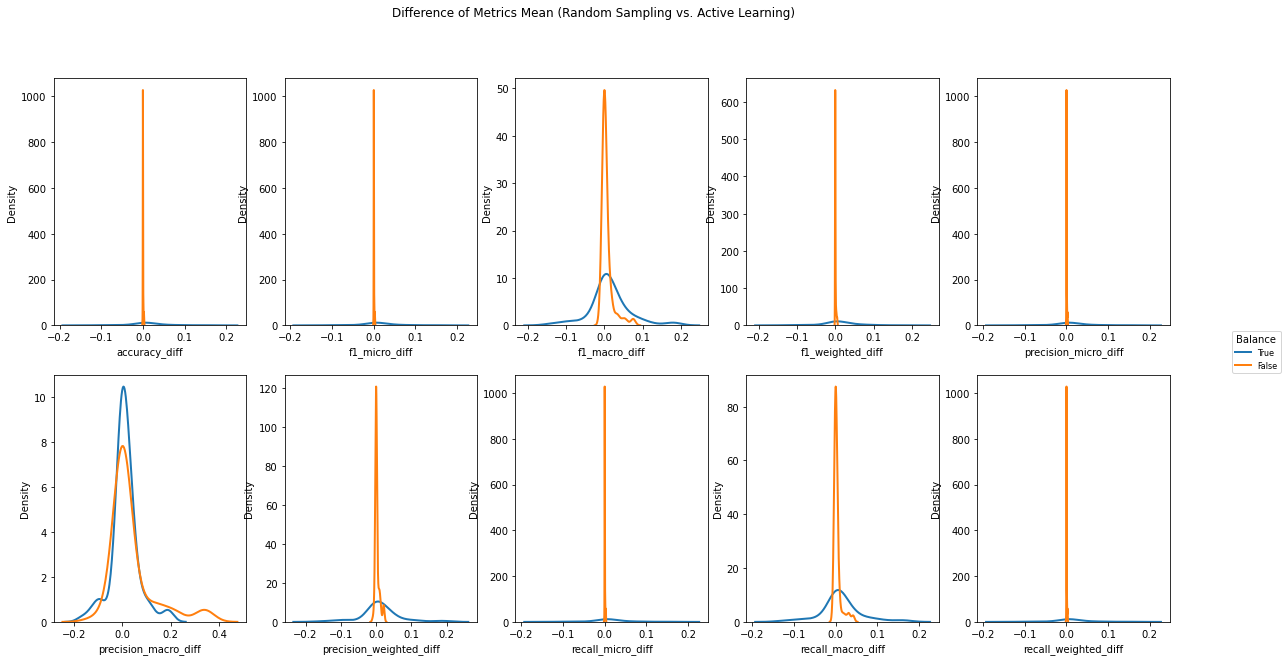

In [24]:
plot_mean_diff(df=sentiment_stats, feat='balance', row=2, col=5, fig=(20, 10), val=[True, False])

**Time**

In [25]:
# Sort by time
rsp_sort_by_time = sentiment[(sentiment['learning_strategy'] == 'random_sampling_probability') & (sentiment['sort_by_time']==True)]
alp_sort_by_time = sentiment[(sentiment['learning_strategy'] == 'active_learning_probability') & (sentiment['sort_by_time']==True)]
prob_pair_t_sort_by_time = one_side_paired_t_test(rsp_sort_by_time, alp_sort_by_time)
prob_pair_t_sort_by_time

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.011140,0.039793,0.004083,0.004358,95,2.728518,0.003790
f1_micro,0.011140,0.039793,0.004083,0.004358,95,2.728518,0.003790
f1_macro,0.014344,0.043505,0.004463,0.006930,95,3.213570,0.000895
f1_weighted,0.011742,0.042855,0.004397,0.004438,95,2.670509,0.004455
precision_micro,0.011140,0.039793,0.004083,0.004358,95,2.728518,0.003790
precision_macro,0.023950,0.081480,0.008360,0.010064,95,2.864935,0.002567
precision_weighted,0.010202,0.045789,0.004698,0.002399,95,2.171667,0.016185
recall_micro,0.011140,0.039793,0.004083,0.004358,95,2.728518,0.003790
recall_macro,0.012610,0.039874,0.004091,0.005815,95,3.082471,0.001343
recall_weighted,0.011140,0.039793,0.004083,0.004358,95,2.728518,0.003790


In [26]:
# Not Sort by time
rsp_not_sort_by_time = sentiment[(sentiment['learning_strategy'] == 'random_sampling_probability') & (sentiment['sort_by_time']==False)]
alp_not_sort_by_time = sentiment[(sentiment['learning_strategy'] == 'active_learning_probability') & (sentiment['sort_by_time']==False)]
prob_pair_t_not_sort_by_time = one_side_paired_t_test(rsp_not_sort_by_time, alp_not_sort_by_time)
prob_pair_t_not_sort_by_time

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.001769,0.029685,0.003046,-0.003290,95,0.580748,0.281393
f1_micro,0.001769,0.029685,0.003046,-0.003290,95,0.580748,0.281393
f1_macro,0.005438,0.033705,0.003458,-0.000307,95,1.572416,0.059589
f1_weighted,0.002283,0.031871,0.003270,-0.003148,95,0.698285,0.243352
precision_micro,0.001769,0.029685,0.003046,-0.003290,95,0.580748,0.281393
precision_macro,0.024202,0.074378,0.007631,0.011527,95,3.171541,0.001021
precision_weighted,0.003198,0.033718,0.003459,-0.002548,95,0.924429,0.178803
recall_micro,0.001769,0.029685,0.003046,-0.003290,95,0.580748,0.281393
recall_macro,0.003556,0.030337,0.003113,-0.001614,95,1.142551,0.128048
recall_weighted,0.001769,0.029685,0.003046,-0.003290,95,0.580748,0.281393


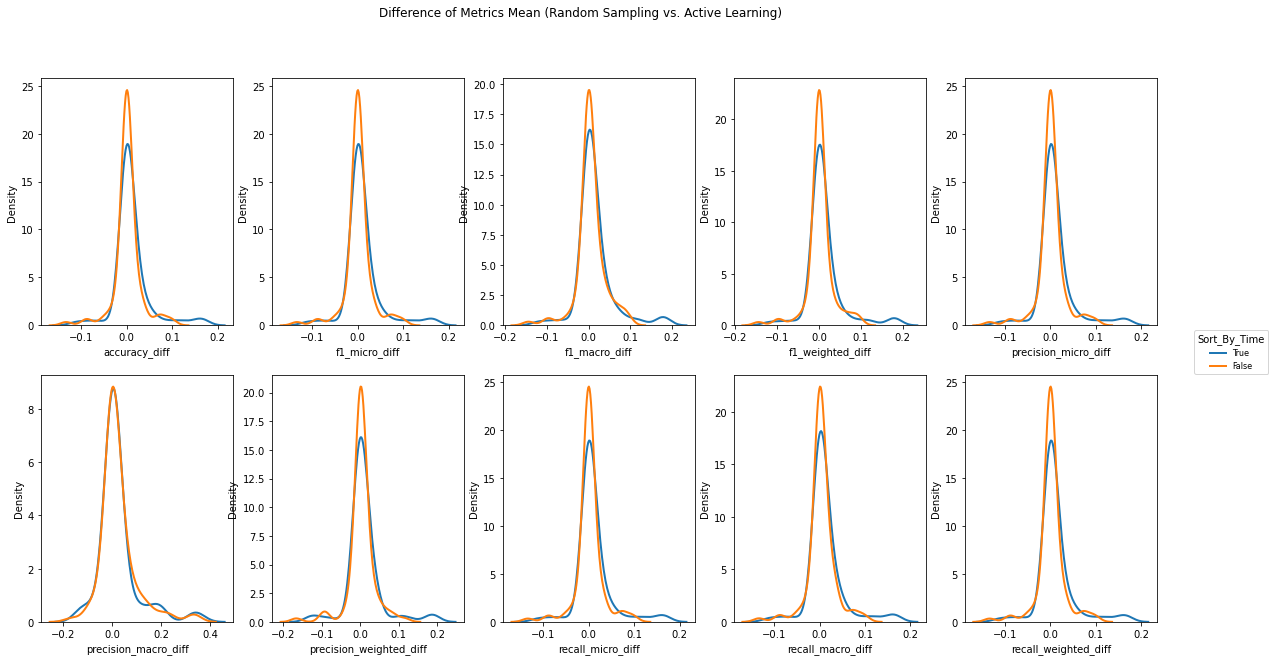

In [27]:
plot_mean_diff(df=sentiment_stats, feat='sort_by_time', row=2, col=5, fig=(20, 10), val=[True, False])

**Partition Ratio**

In [28]:
# Partition Ratio = [0.1, 0.45, 0.45]
rsp_145 = sentiment[(sentiment['learning_strategy'] == 'random_sampling_probability') & (sentiment['partition_ratio']=='[0.1, 0.45, 0.45]')]
alp_145 = sentiment[(sentiment['learning_strategy'] == 'active_learning_probability') & (sentiment['partition_ratio']=='[0.1, 0.45, 0.45]')]
prob_pair_t_145 = one_side_paired_t_test(rsp_145, alp_145)
prob_pair_t_145

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.009906,0.019484,0.002455,0.005808,63,4.035618,0.000075
f1_micro,0.009906,0.019484,0.002455,0.005808,63,4.035618,0.000075
f1_macro,0.011109,0.021128,0.002662,0.006666,63,4.173423,0.000047
f1_weighted,0.009959,0.021360,0.002691,0.005467,63,3.700778,0.000227
precision_micro,0.009906,0.019484,0.002455,0.005808,63,4.035618,0.000075
precision_macro,0.036416,0.079397,0.010003,0.019716,63,3.640438,0.000276
precision_weighted,0.012088,0.020714,0.002610,0.007731,63,4.631664,0.000009
recall_micro,0.009906,0.019484,0.002455,0.005808,63,4.035618,0.000075
recall_macro,0.010466,0.019293,0.002431,0.006408,63,4.305684,0.000030
recall_weighted,0.009906,0.019484,0.002455,0.005808,63,4.035618,0.000075


In [29]:
# Partition Ratio = [0.5, 0.25, 0.25]
rsp_525 = sentiment[(sentiment['learning_strategy'] == 'random_sampling_probability') & (sentiment['partition_ratio']=='[0.5, 0.25, 0.25]')]
alp_525 = sentiment[(sentiment['learning_strategy'] == 'active_learning_probability') & (sentiment['partition_ratio']=='[0.5, 0.25, 0.25]')]
prob_pair_t_525 = one_side_paired_t_test(rsp_525, alp_525)
prob_pair_t_525

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,-0.002172,0.024920,0.003140,-0.007413,63,-0.691769,0.754188
f1_micro,-0.002172,0.024920,0.003140,-0.007413,63,-0.691769,0.754188
f1_macro,0.003641,0.029958,0.003774,-0.002660,63,0.964571,0.169224
f1_weighted,-0.000472,0.027179,0.003424,-0.006188,63,-0.137806,0.554583
precision_micro,-0.002172,0.024920,0.003140,-0.007413,63,-0.691769,0.754188
precision_macro,0.009750,0.059660,0.007516,-0.002798,63,1.297150,0.099655
precision_weighted,-0.000631,0.027589,0.003476,-0.006434,63,-0.181609,0.571764
recall_micro,-0.002172,0.024920,0.003140,-0.007413,63,-0.691769,0.754188
recall_macro,0.000353,0.026221,0.003304,-0.005162,63,0.106894,0.457607
recall_weighted,-0.002172,0.024920,0.003140,-0.007413,63,-0.691769,0.754188


In [30]:
# Partition Ratio = [0.9, 0.05, 0.05]
rsp_905 = sentiment[(sentiment['learning_strategy'] == 'random_sampling_probability') & (sentiment['partition_ratio']=='[0.9, 0.05, 0.05]')]
alp_905 = sentiment[(sentiment['learning_strategy'] == 'active_learning_probability') & (sentiment['partition_ratio']=='[0.9, 0.05, 0.05]')]
prob_pair_t_905 = one_side_paired_t_test(rsp_905, alp_905)
prob_pair_t_905

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.011628,0.051470,0.006485,0.000803,63,1.793184,0.038872
f1_micro,0.011628,0.051470,0.006485,0.000803,63,1.793184,0.038872
f1_macro,0.014922,0.056505,0.007119,0.003038,63,2.096090,0.020048
f1_weighted,0.011550,0.055365,0.006975,-0.000095,63,1.655833,0.051364
precision_micro,0.011628,0.051470,0.006485,0.000803,63,1.793184,0.038872
precision_macro,0.026063,0.089622,0.011291,0.007213,63,2.308200,0.012142
precision_weighted,0.008644,0.060085,0.007570,-0.003994,63,1.141842,0.128921
recall_micro,0.011628,0.051470,0.006485,0.000803,63,1.793184,0.038872
recall_macro,0.013431,0.051703,0.006514,0.002557,63,2.061926,0.021673
recall_weighted,0.011628,0.051470,0.006485,0.000803,63,1.793184,0.038872


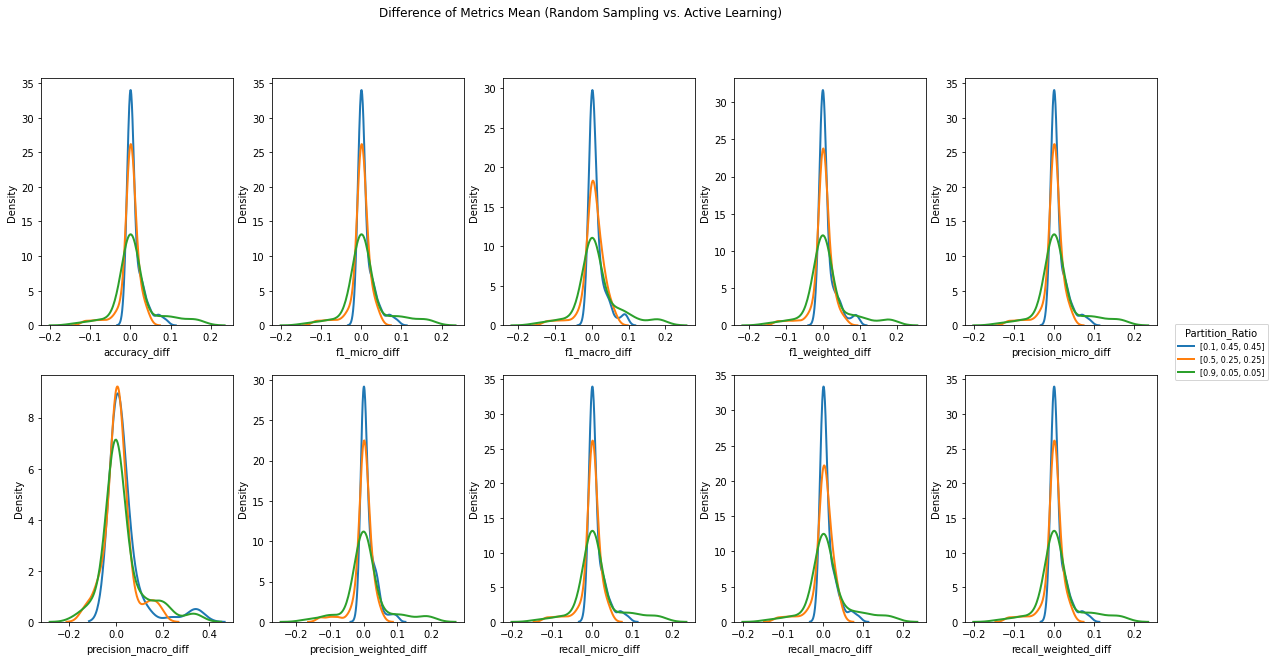

In [31]:
plot_mean_diff(df=sentiment_stats, feat='partition_ratio', row=2, col=5, fig=(20, 10), val=['[0.1, 0.45, 0.45]', '[0.5, 0.25, 0.25]', '[0.9, 0.05, 0.05]'])

#### Sample Size

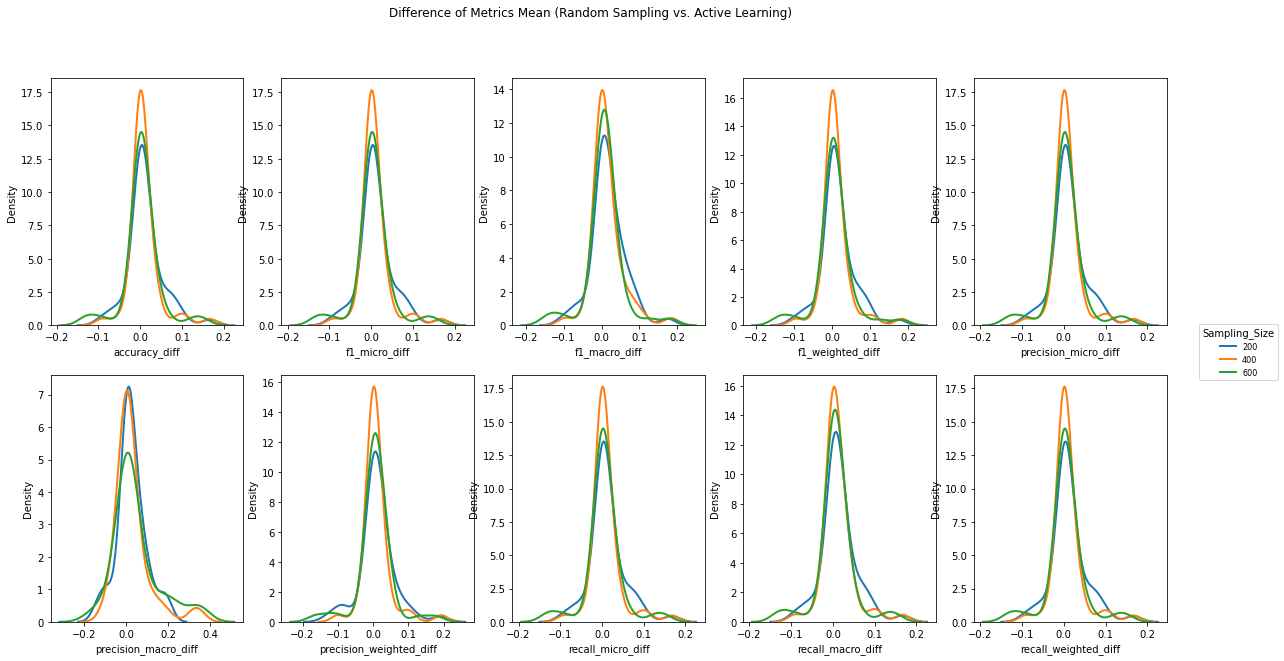

In [32]:
plot_mean_diff(df=sentiment_stats, feat='sampling_size', row=2, col=5, fig=(20, 10), val=[200, 400, 600])

### Choose best settings for Active Learning

In [33]:
def plot_subset(df, row, col, figsize, x, hue):
    # Create grid of subplots
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=figsize)
    # Loop through subplots and create line plots
    hue_colors = {}
    row_ax, col_ax = 0, 0
    for i, ax in enumerate(axes):
        for j in range(5):
            if i == 0:
                y = metric_lst_c[j]+"_diff_probability"
            else:
                y = metric_lst_c[5+j]+"_diff_probability"
            sns.lineplot(data=df, x=x, y=y, hue=hue, ax=ax[j],legend=False)
            ax[j].set_title(y)
        if i == 0:
            for line, name in zip(ax[j].lines, df[hue].unique()):
                hue_colors[name] = line.get_color()

    # Create legend on the side
    handles = [plt.Line2D([0,0],[0,0],color=hue_colors[key]) for key in hue_colors]
    labels = list(hue_colors.keys())
    fig.legend(handles, labels, prop={'size': 8}, title=hue, loc='center right', bbox_to_anchor=(1.1, 0.5))

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axes.flat:
        ax.label_outer()

    # Adjust spacing between subplots and display final plot
    plt.tight_layout()
    plt.show()

**Use Inbalanced data**

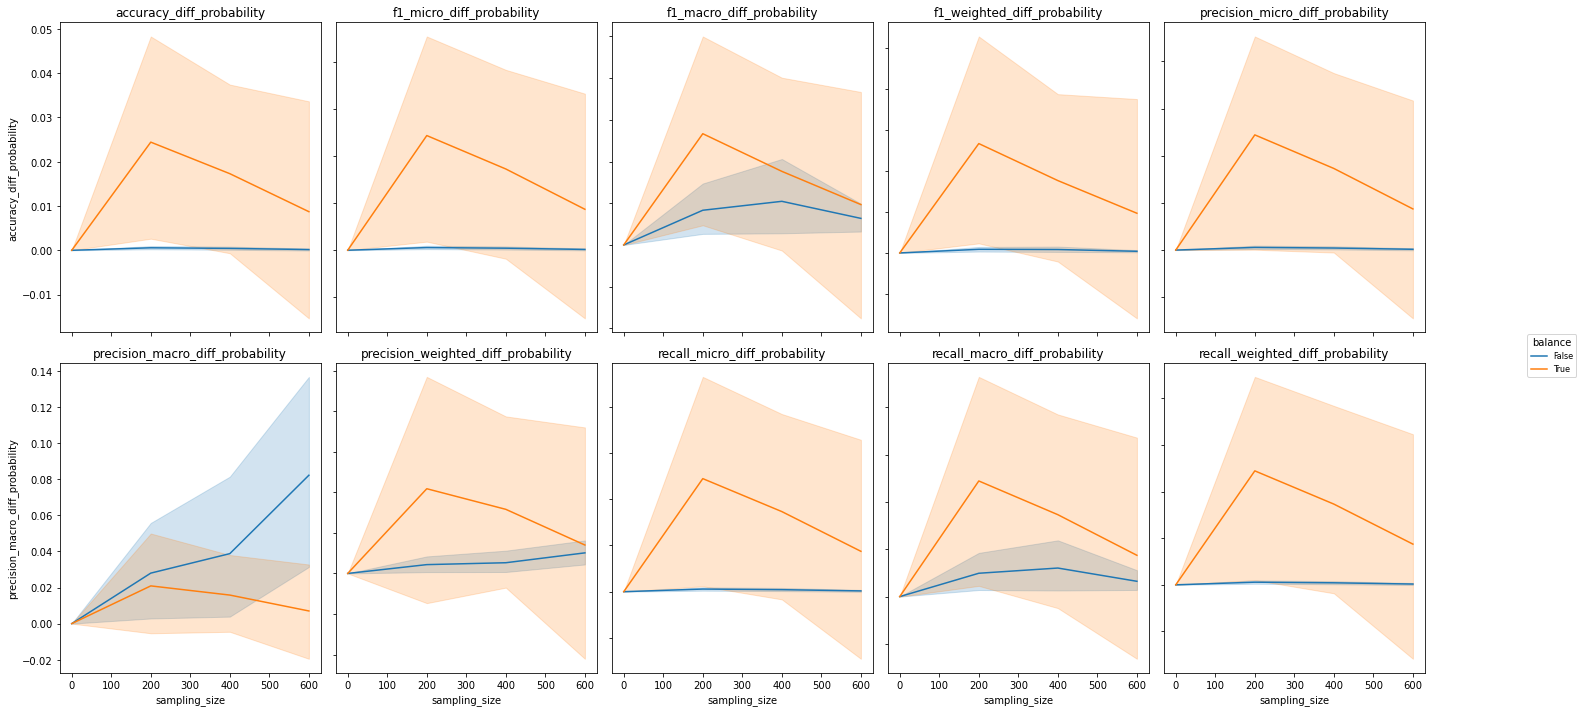

In [34]:
plot_subset(df=sentiment_stats, row=2, col=5, figsize=(20, 10), x="sampling_size", hue="balance")

**Use not sort by time data**

In [35]:
sentiment_stats_inb = sentiment_stats[sentiment_stats['balance'] == False]

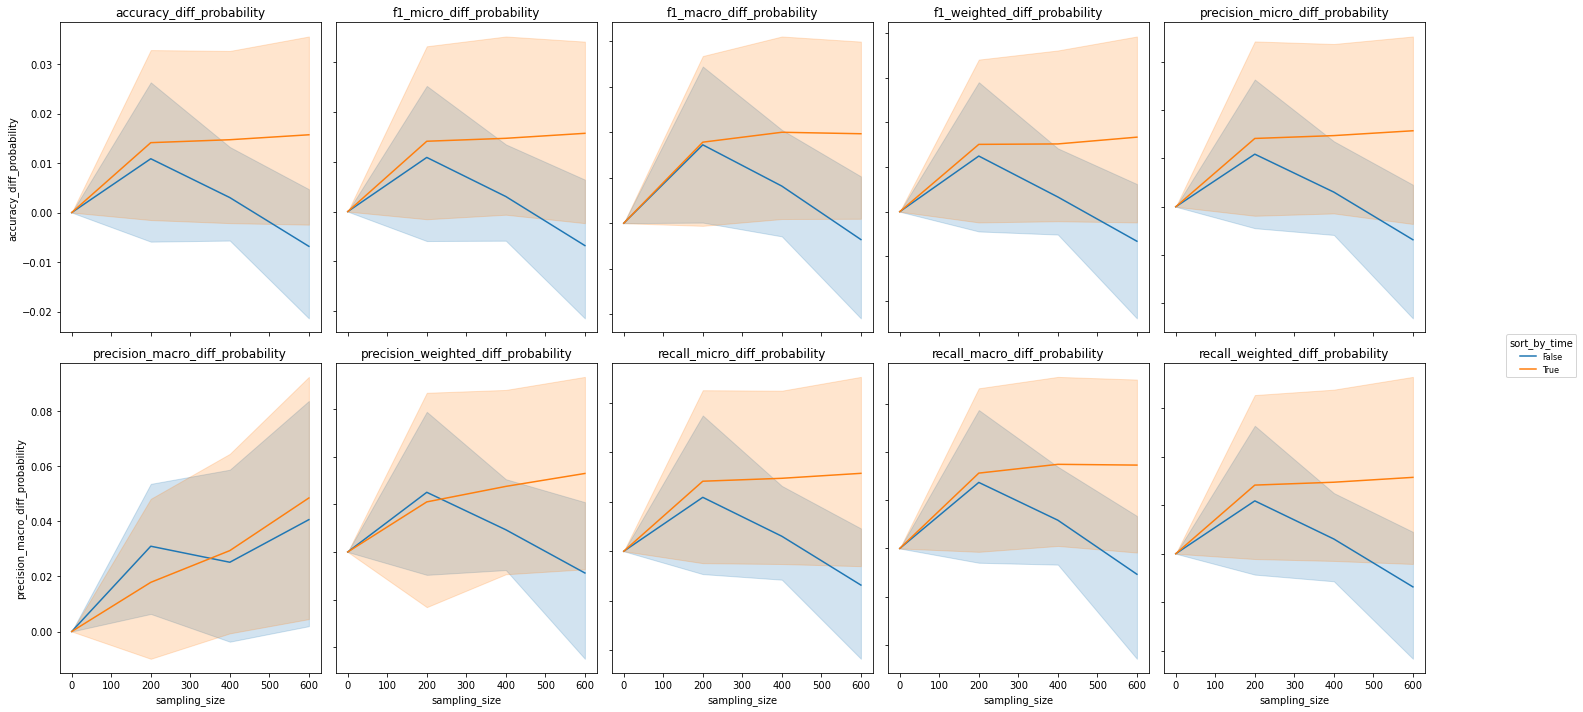

In [36]:
plot_subset(df=sentiment_stats, row=2, col=5, figsize=(20, 10), x="sampling_size", hue="sort_by_time")

In [37]:
sentiment_stats_inb_nst = sentiment_stats_inb[sentiment_stats_inb['sort_by_time'] == False]

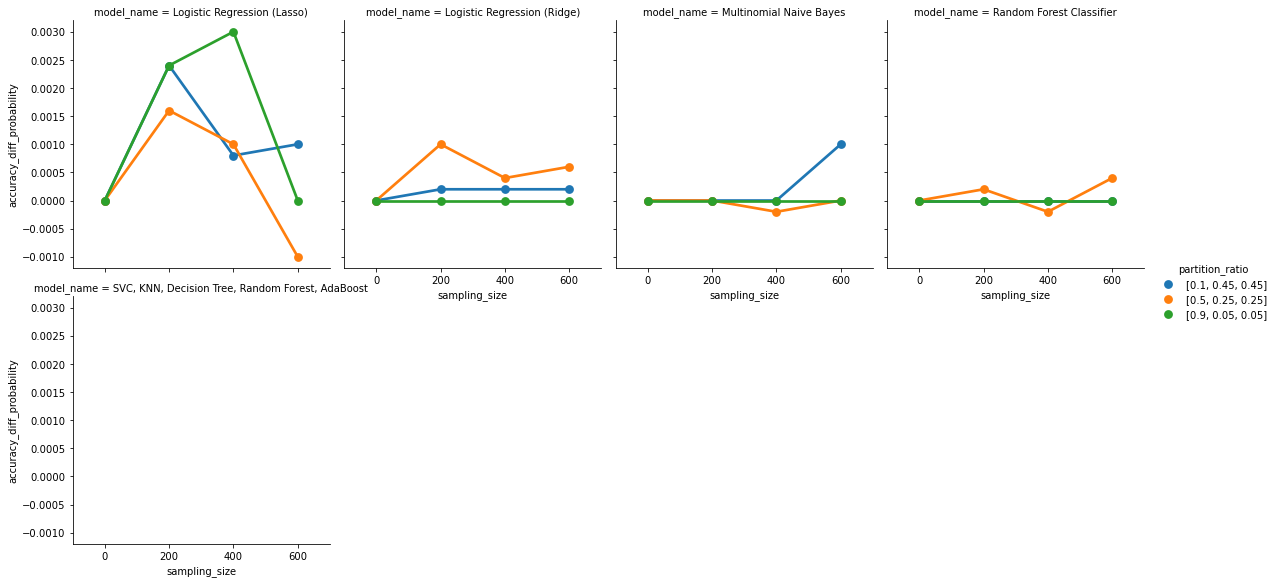

In [38]:
sns.catplot(
    x='sampling_size', 
    y='accuracy_diff_probability', 
    data=sentiment_stats_inb_nst, 
    ci=None,  
    height=4,
    aspect=1,
    kind='point',
    hue='partition_ratio', 
    col='model_name', 
    col_wrap=4);

### Accuracy

In [41]:
sentiment.sort_values(by=['accuracy'], ascending=False).head(10).reset_index(drop=True) #More data, better result

,model_name,balance,sort_by_time,learning_strategy,partition_ratio,sampling_size,accuracy,f1_micro,f1_macro,f1_weighted,precision_micro,precision_macro,precision_weighted,recall_micro,recall_macro,recall_weighted
0,Logistic Regression (Ridge),False,True,active_learning_probability,"[0.5, 0.25, 0.25]",600,0.9620,0.9620,0.4490,0.9480,0.9620,0.6990,0.9480,0.9620,0.407,0.9620
1,Logistic Regression (Ridge),False,False,active_learning_probability,"[0.5, 0.25, 0.25]",600,0.9610,0.9610,0.4150,0.9450,0.9610,0.7100,0.9470,0.9610,0.383,0.9610
2,Logistic Regression (Lasso),False,True,active_learning_probability,"[0.5, 0.25, 0.25]",200,0.9610,0.9610,0.4320,0.9460,0.9610,0.7610,0.9500,0.9610,0.393,0.9610
3,Logistic Regression (Ridge),False,True,random_sampling_probability,"[0.5, 0.25, 0.25]",600,0.9608,0.9608,0.4152,0.9452,0.9608,0.7278,0.9484,0.9608,0.383,0.9608
4,Logistic Regression (Ridge),False,False,random_sampling_probability,"[0.5, 0.25, 0.25]",600,0.9604,0.9604,0.3972,0.9440,0.9604,0.6660,0.9442,0.9604,0.373,0.9604
5,Logistic Regression (Ridge),False,False,active_learning_probability,"[0.5, 0.25, 0.25]",400,0.9600,0.9600,0.3720,0.9420,0.9600,0.6530,0.9420,0.9600,0.358,0.9600
6,Logistic Regression (Lasso),False,True,active_learning_probability,"[0.5, 0.25, 0.25]",0,0.9600,0.9600,0.3950,0.9440,0.9600,0.5290,0.9360,0.9600,0.374,0.9600
7,Logistic Regression (Ridge),False,False,active_learning_probability,"[0.5, 0.25, 0.25]",200,0.9600,0.9600,0.3900,0.9430,0.9600,0.8200,0.9530,0.9600,0.367,0.9600
8,Logistic Regression (Ridge),False,True,active_learning_probability,"[0.5, 0.25, 0.25]",200,0.9600,0.9600,0.3750,0.9420,0.9600,0.8200,0.9520,0.9600,0.359,0.9600
9,Logistic Regression (Lasso),False,True,random_sampling_probability,"[0.5, 0.25, 0.25]",0,0.9600,0.9600,0.3950,0.9440,0.9600,0.5290,0.9360,0.9600,0.374,0.9600


In [42]:
sentiment_stats.sort_values(by=['accuracy_diff_probability'], ascending=False).head(10).reset_index(drop=True) #More data, better result

,model_name,balance,sort_by_time,partition_ratio,sampling_size,accuracy_diff_probability,f1_micro_diff_probability,f1_macro_diff_probability,f1_weighted_diff_probability,precision_micro_diff_probability,...,accuracy_diff_committee,f1_micro_diff_committee,f1_macro_diff_committee,f1_weighted_diff_committee,precision_micro_diff_committee,precision_macro_diff_committee,precision_weighted_diff_committee,recall_micro_diff_committee,recall_macro_diff_committee,recall_weighted_diff_committee
0,Logistic Regression (Lasso),True,True,"[0.9, 0.05, 0.05]",200,0.1670,0.1670,0.1730,0.1730,0.1670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Logistic Regression (Lasso),True,True,"[0.9, 0.05, 0.05]",400,0.1670,0.1670,0.1830,0.1830,0.1670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Logistic Regression (Lasso),True,True,"[0.9, 0.05, 0.05]",600,0.1502,0.1502,0.1818,0.1818,0.1502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Logistic Regression (Ridge),True,True,"[0.9, 0.05, 0.05]",600,0.1250,0.1250,0.1260,0.1260,0.1250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Logistic Regression (Ridge),True,True,"[0.9, 0.05, 0.05]",400,0.1082,0.1082,0.1114,0.1114,0.1082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression (Ridge),True,False,"[0.9, 0.05, 0.05]",200,0.0998,0.0998,0.0954,0.0954,0.0998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Multinomial Naive Bayes,True,False,"[0.9, 0.05, 0.05]",400,0.0920,0.0920,0.0868,0.0868,0.0920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Logistic Regression (Lasso),True,True,"[0.1, 0.45, 0.45]",200,0.0874,0.0874,0.0902,0.0902,0.0874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Multinomial Naive Bayes,True,False,"[0.9, 0.05, 0.05]",200,0.0754,0.0754,0.0678,0.0678,0.0754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Logistic Regression (Lasso),True,False,"[0.1, 0.45, 0.45]",200,0.0716,0.0716,0.0698,0.0698,0.0716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
